In [5]:
from typing import Tuple, List


''' Класс нормировки данных '''
class Normalizer():
    
    '''
    Parameters
    ----------
    dim : int
        Размерность входных данных.
    irr_dim : int
        Количество незначащих переменных.
    range_val_pairs : List[Tuple[float,float]]
        Диапазон значений входных данных.
    norm_min : float, optional
        Нижняя граница нормированных данных (по умолчанию 0).
    norm_max : float, optional
        Верхняя граница нормированных данных (по умолчанию 1).
    '''
    def __init__(self, dim : int, irr_dim : int, range_val_pairs : List[Tuple[float,float]], norm_min : float = 0., norm_max : float = 1.):
        self.dim = dim
        self.irr_dim = irr_dim
        self.range_val_pairs = range_val_pairs
        self.range_val = [(i[1] - i[0]) for i in self.range_val_pairs]
        self.norm_min = norm_min
        self.norm_max = norm_max
        self.range_norm = norm_max - norm_min
    
    
    def __normire(self, entryVal : float, ind : int) -> float:
        '''
        Parameters
        ----------
        entryVal : float
            Входное значение для нормировки.
        ind : int
            Индекс элемента в массиве.

        Returns
        -------
        float
            Нормированное значение.

        '''
        return self.norm_min + ((entryVal - self.range_val_pairs[ind][0]) * self.range_norm / self.range_val[ind])
    
    def __renormire(self, normVal : float, ind : int) -> float:
        '''
        Parameters
        ----------
        normVal : float
            Нормированное значение для денормировки.
        ind : int
            Индекс элемента в массиве.

        Returns
        -------
        float
            Денормированное значение.
        '''
        return self.range_val_pairs[ind][0] + ((normVal - self.norm_min) / self.range_norm * self.range_val[ind])
    
    def normalize(self, data) -> List[List[float]]:
        '''
        Parameters
        ----------
        data : list, array
            Входной набор данных для нормировки.

        Returns
        -------
        List[List[float]]
            Нормированный набор данных.
        '''
        count = 0
        if type(data) == list: 
          count = len(data)
        else:
          count = data.shape[0]
          if count == None:
            count = 1
        normData = []
        for i in range(count):
            cur_sample = []
            for j in range(self.dim):
                cur_sample.append(self.__normire(data[i][j], j))
            for j in range(self.dim, self.dim + self.irr_dim):
                cur_sample.append(data[i][j])
            normData.append(cur_sample)
        return normData
    
    def renormalize(self, normData) -> List[List[float]]:
        '''
        Parameters
        ----------
        normData : list, array
            Нормированный набор данных.

        Returns
        -------
        List[List[float]]
            Денормированный набор данных.
        '''
        count = 0
        if type(normData) == list: 
          count = len(normData)
        else:
          count = normData.shape[0]
          if count == None:
            count = 1
        data = []
        for i in range(count):
            cur_sample = []
            for j in range(self.dim):
                cur_sample.append(self.__renormire(normData[i][j], j))
            for j in range(self.dim, self.dim + self.irr_dim):
                cur_sample.append(normData[i][j])
            data.append(cur_sample)
        return data


In [ ]:
import numpy as np
import random
import pandas as pd
!pip install git+https://github.com/naught101/sobol_seq@v0.2.0#egg=sobol_seq
import sobol_seq
!pip install smt
from smt.sampling_methods import LHS
import time
from typing import Tuple, List


''' Класс генерации данных '''
class DataGenerator():

    '''
    Parameters
    ----------
    dim: int
        Размерность входных данных.
    val_range : List[Tuple[float,float]]
        Диапазон значений входных данных.
    '''
    def __init__(self, dim : int, val_range : List[Tuple[float,float]]):
        try:
            assert dim  == len(val_range), 'Размерность входных диапазонов не равна входной размерности!'
            self.dim = dim
            self.val_range = val_range
            random.seed(int(time.time()))
        except AssertionError as e:
            raise AssertionError(e.args[0])
    

    def get_random(self, samples_num : int, irrelevant_var_count : int = 0, write_in_file : bool = False) -> List[List[float]]:
        '''
        Рандомная генерация данных.
        Parameters
        ----------
        samples_num : int
            Количество записей.
        irrelevant_var_count : int, optional
            Количество незначащих переменных. По умолчанию 0.
        write_in_file : bool, optional
            Запись в файл. По умолчанию False.

        Returns
        -------
        List[List[float]]
            Список записей.
        '''
        arr = []
        for k in range(samples_num):
            sample = []
            # добавляем существенные переменные
            for i in self.val_range:
                sample.append(random.uniform(i[0], i[1]))
            # добавляем несущественные переменные
            if irrelevant_var_count != 0:
                for i in range(irrelevant_var_count):
                    sample.append(random.uniform(0., 1.))
            arr.append(sample)
        if write_in_file:
            col = [('x' + str(i+1)) for i in range(self.dim + irrelevant_var_count)]
            df = pd.DataFrame(arr, columns=col)
            df.to_csv(f'../../DataSet/random_{self.dim}_{samples_num}_{irrelevant_var_count}.csv')
        return list(arr)
    

    def get_sobol(self, samples_num : int, irrelevant_var_count : int = 0, write_in_file : bool = False) -> List[List[float]]:
        '''
        Генерация данных от 0 до 1 методом Sobol.
        Parameters
        ----------
        samples_num : int
            Количество записей.
        irrelevant_var_count : int, optional
            Количество незначащих переменных. По умолчанию 0.
        write_in_file : bool, optional
            Запись в файл. По умолчанию False.

        Returns
        -------
        List[List[float]]
            Список записей.
        '''
        arr = sobol_seq.i4_sobol_generate(self.dim, samples_num)
        if irrelevant_var_count != 0:
            zeros = [[0] for i in range(irrelevant_var_count)]
            arr = np.insert(arr, obj=self.dim, values=zeros, axis=1)
        if write_in_file:
            col = [('x' + str(i+1)) for i in range(self.dim + irrelevant_var_count)]
            df = pd.DataFrame(arr, columns=col)
            df.to_csv(f'../DataSet/sobol_{self.dim}_{samples_num}_{irrelevant_var_count}.csv')
        return list(arr)
    
    def get_lsh(self, samples_num : int, irrelevant_var_count : int = 0, write_in_file : bool = False) -> List[List[float]]:
        '''
        Генерация данных методом латинского гиперкуба LSH.
        Parameters
        ----------
        samples_num : int
            Количество записей.
        irrelevant_var_count : int, optional
            Количество незначащих переменных. По умолчанию 0.
        write_in_file : bool, optional
            Запись в файл. По умолчанию False.

        Returns
        -------
        List[List[float]]
            Список записей.
        '''
        xlimits = np.array(self.val_range)
        sampling = LHS(xlimits=xlimits, criterion = 'corr')
        arr = sampling(samples_num)
        if irrelevant_var_count != 0:
            zeros = [[0] for i in range(irrelevant_var_count)]
            arr = np.insert(arr, obj=self.dim, values=zeros, axis=1)
        if write_in_file:
            col = [('x' + str(i+1)) for i in range(self.dim + irrelevant_var_count)]
            df = pd.DataFrame(arr, columns=col)
            df.to_csv(f'../DataSet/lsh_{self.dim}_{samples_num}_{irrelevant_var_count}.csv')
        return list(arr)
    
    def get_from_file(self, filename : str) -> List[List[float]]:
        '''
        Parameters
        ----------
        filename : str
            Имя файла.

        Raises
        ------
        OSError
            Файл не найден.

        Returns
        -------
        List[List[float]]
            Список записей.
        '''
        try:
            return list(pd.read_csv(filename, index_col=0).to_numpy('float32'))
        except OSError as e:
            raise OSError(e.args[0])

In [7]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
import keras.backend as K
from keras.layers import Lambda
import numpy as np

''' Класс автоэнкодеров '''
class AutoencoderClass():
  def __init__(self, func, input_dim : int, encoding_dim : int, enc_type : str, normalizer : Normalizer):
    self.func = func                 # Функция обучения
    self.batch = 0                   # Размр батча
    self.input_dim = input_dim       # Размерность входного представления
    self.encoding_dim = encoding_dim # Размерность кодированного представления
    self.enc_type = enc_type         # Тип автоэнкодера
    self.normalizer = normalizer     # Нормировщик функции
    try:
      # Сборка моделей
      self.encoder, self.decoder, self.autoencoder = self.aec_types[self.enc_type]()
      if self.enc_type != 'vae':
        self.autoencoder.compile(optimizer = 'adam', loss = self.custom_loss, metrics=['accuracy'])
      else:
        self.autoencoder.compile(optimizer = 'adam', loss = self.vae_loss, metrics=['accuracy'])
    except KeyError as e:
      raise ValueError('Undefined unit: {}'.format(e.args[0]))

  # Обучение модели
  def fit(self, train_data, test_data, epochs : int, batch_size : int, shuffle : bool):
    self.batch = batch_size
    if self.enc_type != 'conv':
      self.autoencoder.fit(train_data, train_data,
                           epochs=epochs,
                           batch_size=self.batch,
                           shuffle=shuffle,
                           validation_data=(test_data, test_data))
    else:
      grid_train = []
      grid_test = []
      for i in range(len(train_data)):
        xx, yy = np.meshgrid(train_data[i], train_data[i])
        grid_train.append(xx)

      for i in range(len(test_data)):
        xx, yy = np.meshgrid(test_data[i], test_data[i])
        grid_test.append(xx)
      
      self.autoencoder.fit(grid_train, grid_train,
                           epochs=epochs,
                           batch_size=self.batch,
                           shuffle=shuffle,
                           validation_data=(grid_test, grid_test))

  # Предсказание результата
  def predict(self, x_vector):
    if self.enc_type != 'conv':
      return self.autoencoder.predict(x_vector)
    else:
      return self.autoencoder.predict(x_vector)[0]

  # Тип автоэнкодера
  @property
  def type(self):
    return self.enc_type

  @classmethod
  def get_aec_types(self):
    self.aec_types = {'dense': self.__create_dense_ae,
                      'deep':  self.__create_deep_dense_ae,
                      'vae':   self.__create_vae}
    return list(self.aec_types.keys())

  # Возвращает собранные модели
  def get_models(self):
    return self.autoencoder, self.encoder, self.decoder

  # Сохранение весов модели
  def save(self, file : str):
    self.autoencoder.save_weights(file)

  # Загрузка весов модели
  def load(self, file : str):
    self.autoencoder.load_weights(file)
  
  # создание модели по параметрам из файла
  @staticmethod
  def create_from_file(file : str):
    with open(file, 'r') as f:
      f_name = f.readline().split(':')[1].strip(' \n') # func name
      p_1 = int(f.readline().split(':')[1])   # epochs
      p_2 = int(f.readline().split(':')[1])   # batch
      p_3 = int(f.readline().split(':')[1])   # enc dim
      p_4 = float(f.readline().split(':')[1]) # percent
    
    s_1 = int(file.split('_')[2]) # dim
    enc_type = file.split('_')[1] # type
    func = TestFunctions.get_func(f_name)
    _, _, _, _, norm = func.get_params()
    model = AutoencoderClass(func, s_1, p_3, enc_type, norm)
    model.batch = p_2
    if os.path.isfile(file.replace('.txt', '.h5')):
      model.load(file.replace('.txt', '.h5'))
    return model

  # Loss функция
  @tf.autograph.experimental.do_not_convert
  def custom_loss(self, x_true, x_pred):
    return K.mean(K.abs(self.func(self.normalizer.renormalize(x_pred)[0]) - self.func(self.normalizer.renormalize(x_true)[0])))

  # Loss функция для вариационного автоэнкодера
  @tf.autograph.experimental.do_not_convert
  def vae_loss(self, x_true, x_pred):
    x_true = K.reshape(x_true, shape=(self.batch, self.input_dim))
    x_pred = K.reshape(x_pred, shape=(self.batch, self.input_dim))
    loss = self.custom_loss(x_true, x_pred)
    kl_loss = -0.5 * K.sum(1 + self.z_log_var - K.square(self.z_mean) - K.exp(self.z_log_var))
    return loss + kl_loss

  ''' Сжимающий автоэнкодер '''
  def __create_dense_ae(self):
    # Энкодер
    input_data = Input(shape=(self.input_dim))
    encoded = Dense(self.encoding_dim, activation = 'relu')(input_data)
    
    # Декодер
    input_encoded = Input(shape = (self.encoding_dim))
    decoded = Dense(self.input_dim, activation = 'sigmoid')(input_encoded)

    # Модели
    encoder = Model(input_data, encoded, name = "encoder")
    decoder = Model(input_encoded, decoded, name = "decoder")
    autoencoder = Model(input_data, decoder(encoder(input_data)), name = "autoencoder")
    return encoder, decoder, autoencoder

  ''' Глубокий автоэнкодер '''
  def __create_deep_dense_ae(self):
    # Энкодер
    input_data = Input(shape=(self.input_dim))
    x = Dense(self.encoding_dim*2, activation='relu')(input_data)
    encoded = Dense(self.encoding_dim, activation='linear')(x)
    
    # Декодер
    input_encoded = Input(shape=(self.encoding_dim,))
    x = Dense(self.encoding_dim*2, activation='relu')(input_encoded)
    decoded = Dense(self.input_dim, activation='sigmoid')(x)
    
    # Модели
    encoder = Model(input_data, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_data, decoder(encoder(input_data)), name="autoencoder")
    return encoder, decoder, autoencoder

  ''' Сверточный автоэнкодер '''
  def __create_deep_conv_ae(self):
    # Энкодер
    input_data = Input(shape=(self.input_dim, self.input_dim, 1))
    x = Conv2D(25, (2, 2), activation='relu', padding='same')(input_data)
    x = MaxPooling2D((2, 2), padding='same')(x)
    #x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
    #x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (2, 2), activation='relu', padding='same')(x)

    # На этом моменте представление  (7, 7, 1) т.е. 49-размерное
    
    # Декодер
    input_encoded = Input(shape=(7, 7, 1))
    #x = Conv2D(32, (7, 7), activation='relu', padding='same')(input_encoded)
    #x = UpSampling2D((2, 2))(x)
    x = Conv2D(25, (2, 2), activation='relu', padding='same')(input_encoded)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (2, 2), activation='sigmoid', padding='same')(x)

    # Модели
    encoder = Model(input_data, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_data, decoder(encoder(input_data)), name="autoencoder")
    return encoder, decoder, autoencoder

  ''' Вариационный автоэнкодер '''
  def __create_vae(self):
    hidden_dim = 2

    input_data = Input(shape=(self.input_dim))
    x = Dense(self.encoding_dim, activation='relu')(input_data)
    
    self.z_mean = Dense(self.encoding_dim)(x)    # Мат ожидание
    self.z_log_var = Dense(self.encoding_dim)(x) # Логарифм дисперсии
    
    # Нормальное распределение N(0, 1)
    def noiser(args):
      self.z_mean, self.z_log_var = args
      N = K.random_normal(shape=(self.batch, self.encoding_dim), mean=0., stddev=1.0)
      return K.exp(self.z_log_var / 2) * N + self.z_mean
    
    # Преобразование данных в нормальное распределения
    h = Lambda(noiser, output_shape=(self.encoding_dim,))([self.z_mean, self.z_log_var])
    
    input_encoded = Input(shape=(self.encoding_dim,))
    d = Dense(self.encoding_dim, activation='relu')(input_encoded)
    decoded = Dense(self.input_dim, activation='sigmoid')(d)
    
    encoder = Model(input_data, h, name='encoder')
    decoder = Model(input_encoded, decoded, name='decoder')
    vae = Model(input_data, decoder(encoder(input_data)), name="vae")
    return encoder, decoder, vae

In [21]:
from typing import Tuple, List
import tensorflow as tf
import math

''' Класс функции '''
class Function():
    def __init__(self, func, name : str, dim : int, irr_dim : int, data_range : List[Tuple[float,float]]):
        '''
        Объект функции включает в себя:

        Parameters
        ----------
        func : function, lambda
            Непостредственно функция.
        name : str
            Название функции.
        dim : int
            Размерность пространства.
        irr_dim : int
            Количество незначащих переменных. Соответственно, размерность функции (dim - irr_dim).
        data_range : List[Tuple[float,float]]
            Область опредеоления. Диапазон значений значащих переменных.

        '''
        self.func = func
        self.name = name
        self.dim = dim
        self.irr_dim = irr_dim
        self.data_range = data_range
        self.generator = DataGenerator(self.dim, self.data_range)
        self.normalizer = Normalizer(self.dim, self.irr_dim, self.data_range)
        
    def __call__(self, x):
        return self.func(x)
        
    def get_params(self):
        return self.dim, self.irr_dim, self.data_range, self.generator, self.normalizer
    
    @property
    def func_name(self):
      return self.name
    

''' Класс тестовых функций '''
class TestFunctions():
    def __init__(self):
        pass
    
    @classmethod
    def get_func_names(self):
        self.functions = {
            'func_1' : self.func_1,
            'func_2' : self.func_2,
            'func_3' : self.func_3,
            'func_4' : self.func_4,
        }
        return list(self.functions.keys())

    @classmethod
    def get_func(self, name : str):
        self.get_func_names()
        return self.functions[name](self)

    def func_1(self):
        def f(x):
            return tf.math.pow(x[0],2) + tf.math.pow(x[1],2) + tf.math.pow(x[2],2) + tf.math.pow(x[3],2) + tf.math.pow(x[4],2) + tf.math.pow(x[5],2) + tf.pow(x[6],2) + tf.pow(x[7],2)
        
        data_range = [(0, 100), (0, 100), (0, 100), (0, 100), (0, 100), (0, 100),  (0, 100), (0, 100)]
        func = Function(f, 'func_1', 8, 0, data_range)
        return func
        
    def func_2(self):
        def f(x):
            return tf.math.pow(x[0],4) + 4 * tf.math.pow(x[0],3) * x[1] + 6 * tf.math.pow(x[0],2) + tf.math.pow(x[1],2) + 4 * x[0] * tf.math.pow(x[1],3) + tf.math.pow(x[1],4)
        
        data_range = [(0, 25), (0, 25)]
        func = Function(f, 'func_2', 2, 2, data_range)
        return func
    
    def func_3(self):
        def f(x):
            return tf.math.pow(x[0] - 100, 2) + tf.math.pow(x[1] + 3, 2) + 5 * tf.math.pow(x[2] + 10, 2)
        
        data_range = [(0, 100), (0, 100), (0, 100)]
        func = Function(f, 'func_3', 3, 3, data_range)
        return func
    
    def func_4(self):
        def f(x):
            return tf.math.pow(x[0] - 1, 2) + tf.math.pow(x[1], 2) + x[2] + 2 * x[3] + tf.math.pow(x[4], 3) + x[5]
        
        data_range = [(0, 100), (0, 100), (0, 100), (0, 100), (0, 100)]
        func = Function(f, 'func_4', 6, 4, data_range)
        return func


In [9]:
from smt.applications import EGO
from smt.sampling_methods import LHS
import sys
import numpy as np
from sklearn.metrics import mean_absolute_error
import random

''' Класс подбора параметров '''
class ParamsSelection():
    def __init__(self):
        pass
    
    def __compare(self, func : Function, orig_data, pred_data):
        '''
        Расчёт отклонения между эталонными и предсказанными данными

        Parameters
        ----------
        func : Function
            Исходная функция.
        orig_data : list
            Эталонный набор данных.
        pred_data : list
            Предсказанный набор данных.
        
        Returns
        -------
        error : float
            Значение ошибки абсолютного отклонения.
        
        '''
        y_orig = [func(x) for x in orig_data]
        y_pred = [func(x) for x in pred_data]
        y_error = mean_absolute_error(y_orig, y_pred)
        return y_error
        
    def brute_force(self, enc_type : str, func : Function, n : int):
        '''
        Полный перебор

        Parameters
        ----------
        enc_type : str
            Тип автоэнкодера.
        func : Function
            Функция для подбора параметров.
        n : int
            Размер генерируемого датасета.

        Returns
        -------
        hp_list : List
            Оптимальный набор параметров.
        error : float
            Оптимальное значение ошибки.

        '''
        
        h_epoch = 5
        h_size = 1
        h_percent = 0.1
        dim, irr_dim, _, generator, normalizer = func.get_params()
        error = sys.float_info.max
        rand_samles_count = 200
        rand_data = generator.get_lsh(rand_samles_count, irr_dim)
        norm_data = normalizer.normalize(rand_data)
        hp_list = list()
        for epoch in range(5, 60, h_epoch):
          for batch in  [2**i for i in range(4, 9)]:
            for size in range(dim // 2, dim, h_size):
              for percent in np.arange(0.5, 1.0, h_percent):
                  sobol_data = generator.get_sobol(n, irr_dim)
                  random.shuffle(sobol_data)
                  data_train = np.array(sobol_data[0:int(n * percent)])
                  data_test = np.array(sobol_data[int(n * percent):n])
                  model = AutoencoderClass(func, dim + irr_dim, size, enc_type, normalizer)
                  model.fit(data_train, data_test, epoch, batch, True)
                  pred_data = normalizer.renormalize([model.predict(np.array(x).reshape(1,dim + irr_dim))[0] for x in norm_data])
                  cur_error = self.__compare(func, rand_data, pred_data)
                  if cur_error < error:
                    model.save(f'brute_force_{enc_type}_{dim + irr_dim}_{size}.h5')    
                    error = cur_error
                    hp_list.clear()
                    hp_list.append(epoch)
                    hp_list.append(batch)
                    hp_list.append(size)
                    hp_list.append(percent)
        
        with open(f'brute_force_{enc_type}_{dim + irr_dim}_{hp_list[2]}.txt', 'w') as f:
            f.write(f'func name: {func.func_name}\nepochs: {hp_list[0]}\nbatch: {hp_list[1]}\nencoded dim: {hp_list[2]}\nsample split: {hp_list[3]}')
        return hp_list, error
    
    def ego(self, enc_type : str, func : Function,  n : int, ndoe : int, n_iter : int):
        '''
        Метод EGO - эффективная глобальная оптимизация

        Parameters
        ----------
        enc_type : str
            Тип автоэнкодера.
        func : Function
            Функция для подбора параметров.
        n : int
            Размер генерируемого датасета.
        ndoe : int
            Количесто начальных сгенерированных точек.
        n_iter : int
            Максимальное количество итераций алгоритма.

        Returns
        -------
        x_opt : List
            Оптимальный набор параметров.
        error : float
            Оптимальное значение ошибки.

        '''
        
        dim, irr_dim, _, generator, normalizer = func.get_params()
        rand_samles_count = 200
        rand_data = generator.get_lsh(rand_samles_count, irr_dim)
        norm_data = normalizer.normalize(rand_data)

        def predict_params(x):
            ''' 
            x[0] - число эпох
            x[1] - батчсайз
            x[2] - размер сжатия
            x[3] - разбиение выборки
            '''
            count, n_param = x.shape
            res = np.zeros((count,1))
            
            for i in range(count):
              sobol_data = generator.get_sobol(n, irr_dim)
              random.shuffle(sobol_data)
              data_train = np.array(sobol_data[0:int(n * x[i][3])])
              data_test = np.array(sobol_data[int(n * x[i][3]):n])
              model = AutoencoderClass(func, dim + irr_dim, int(x[i][2]), enc_type, normalizer)
              model.fit(data_train, data_test, int(x[i][0]), int(x[i][1]), True)
              model.save(f'ego_{enc_type}_{dim + irr_dim}_{int(x[i][2])}.h5')
              pred_data = normalizer.renormalize([model.predict(np.array(xx).reshape(1,dim + irr_dim))[0] for xx in norm_data])
              res[i] = self.__compare(func, rand_data, pred_data)
            return res
        
        xlimits = np.array([[5,60], [16,256], [dim//2, dim - 1], [0.5, 1.0]])
        criterion='EI'
        sampling = LHS(xlimits=xlimits, random_state=3)
        xdoe = sampling(ndoe)
        ego = EGO(n_iter=n_iter, criterion=criterion, xdoe=xdoe, xlimits=xlimits)
        x_opt, error, _, _, _ = ego.optimize(fun=predict_params)
        x_opt = [int(x_opt[0]), int(x_opt[1]), int(x_opt[2]), x_opt[3]]
        with open(f'ego_{enc_type}_{dim + irr_dim}_{x_opt[2]}.txt', 'w') as f:
            f.write(f'func name: {func.func_name}\nepochs: {x_opt[0]}\nbatch: {x_opt[1]}\nencoded dim: {x_opt[2]}\nsample split: {x_opt[3]}')
        return x_opt, error


In [ ]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout


if __name__ == "__main__":
    test = TestFunctions()
    func = test.func_1()
    
    optimizer = ParamsSelection()
    with suppress_stdout():
        x_opt, y_err = optimizer.ego('dense', func, 60000, 6, 15)
    
    print(f'Opt params:\nepochs = {x_opt[0]}\nbatch = {x_opt[1]}\nencoded dim = {x_opt[2]}\nsample split = {x_opt[3]*100:.3f} % : {(1.0 - x_opt[3])*100:.3f} %')
    print(f'Opt mean Y error: {y_err[0]}')
    

Opt params:
epochs = 34
batch = 16
encoded dim = 7
sample split = 100.000 % : 0.000 %
Opt Y error: [1282.6521068]


In [10]:
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

''' Класс подсчёта ошибки '''
class ErrorCalculate():
  def __init__(self, func : Function):
      self.func = func
      self.dim, self.irr_dim, self.data_range, self.generator, self.normalizer = self.func.get_params()

  def calculate(self, aec : AutoencoderClass, num_samples : int = 1000):
      '''
        Расчёт ошибки: средней и по сегментам

        Parameters
        ----------
        aec : AutoencoderClass
            Объект обученного автоэнкодера.
        num_samples : int
            Размер выборки для подсчёта средней ошибки.

        Returns
        -------
        y_mean_error : float
            Средняя ошибка по всем предсказаниям.
        fig : pyplot
            График ошибок по сегментам.
      '''
      rand_data = self.generator.get_lsh(num_samples)
      norm_data = self.normalizer.normalize(rand_data)
      pred_data = self.normalizer.renormalize([aec.predict(np.array(xx).reshape(1,self.dim + self.irr_dim))[0] for xx in norm_data])
      y_orig = [self.func(x) for x in rand_data]
      y_pred = [self.func(x) for x in pred_data]
      # средняя ошибка по всем предсказаниям
      y_mean_error = mean_absolute_error(y_orig, y_pred)

      # средняя ошибка по кластерам
      fig = plt.figure(figsize = (4 * self.dim, 4))
      samp_n = num_samples // 10
      for i in range(self.dim):
        a, b = self.data_range[i]
        h = (b - a) / 10
        err = []
        names = []
        for k in np.arange(a, b, h):
          d_r = self.data_range.copy()
          d_r[i] = (k, k + h)
          names.append(f'{k:.1f}-{k+h:.1f}')
          cur_generator = DataGenerator(self.dim, d_r)
          r_data = cur_generator.get_lsh(samp_n, self.irr_dim)
          n_data = self.normalizer.normalize(r_data)
          p_data = self.normalizer.renormalize([aec.predict(np.array(xx).reshape(1,self.dim + self.irr_dim))[0] for xx in n_data])
          y_orig = [self.func(x) for x in r_data]
          y_pred = [self.func(x) for x in p_data]
          y_error = mean_absolute_error(y_orig, y_pred)
          err.append(y_error)
        
        ax = fig.add_subplot(1, self.dim, (i+1))
        color = np.random.rand(3)
        ax.bar(names, err, color = color)
        for tick in ax.get_xticklabels():
          tick.set_rotation(35)
      
      fig.suptitle('Mean Y error for each parameter', fontsize = 16)
      fig.savefig(f'{self.func.name}_{aec.type}_error.png')
      return y_mean_error, fig

Mean Y error: 1216.761


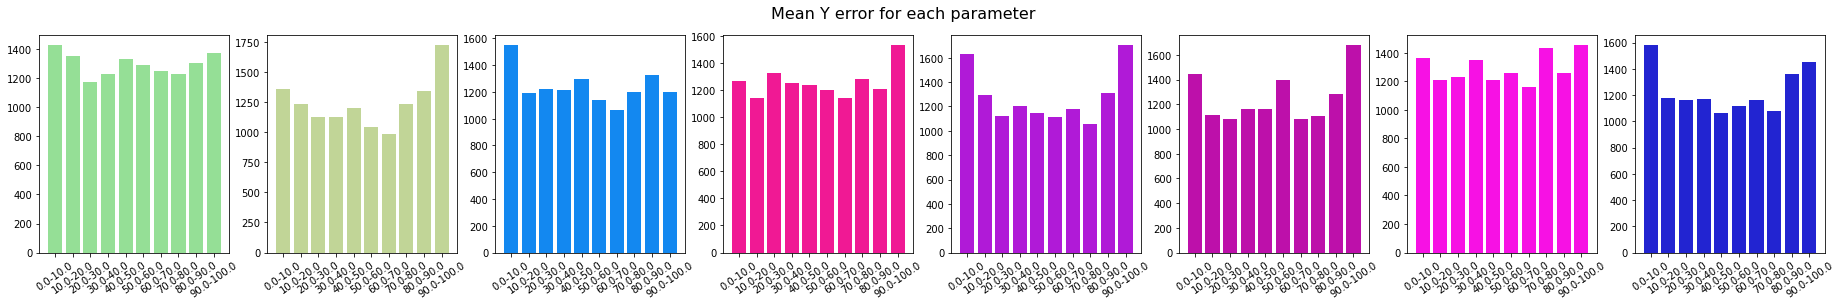

In [ ]:
if __name__ == '__main__':
  test = TestFunctions()
  func = test.func_1()
  model = AutoencoderClass.create_from_file('ego_dense_8_7.txt')

  err_calc = ErrorCalculate(func)

  error, fig = err_calc.calculate(model)
  print(f'Mean Y error: {error:.3f}')
  fig.show()

In [23]:
l =TestFunctions.get_func_names()
l + ['all']

['func_1', 'func_2', 'func_3', 'func_4', 'all']